## Audio Classification: Classify the type of sound from the audio.

### Dataset

In this capstone project, [UrbanSound8K Audio Dataset](https://urbansounddataset.weebly.com) was used. The dataset is comprised of 8732 slices (audio excerpts) of up to 4 s in duration extracted from field recordings crawled from the Freesound online archive.

Each slice contains one of 10 possible sound sources: 
**air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, street music.**

The sources were selected from the Urban Sound Taxonomy based on the high frequency with which they appear in noise complaints as determined from the data provided by New York City’s 311 service (over 370,000 complaints from 2010 to date)

Since these are real field-recordings, it is possible (and often the case) for there to be other sources present in a slice in addition to the labeled source. All slices have been manually annotated with the source ID and a subjective judgement of whether the source is in the foreground or background.

To facilitate comparable research, the slices in UrbanSound8K come pre-sorted into 10 folds using a stratified approach which ensures that slices from the same recording will not be used both for training and testing, which could potentially lead to artificially high results. 

### Preprocessing

We used the VGG-like model to generate the 128-dimensional features using the [audioset](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) library available in the TensorFlow models Github repository, along with supporting code for audio feature generation, embedding postprocessing, and demonstrations of the model in inference and training modes.

After extracting the features, we will perform clustering analysis using various algorithms and analyze the adjusted Rand Index and Silhouette Scores. We will then choose the best one to perform visualizations to gain insights.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix as sm
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse 
%matplotlib inline
import seaborn as sns
import os
import pickle
import scipy
from scipy.special import comb
plt.rcParams['figure.figsize'] = 15, 8

current_palette = sns.color_palette()
from timeit import default_timer as timer
from time import time
from datetime import datetime

from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder, normalize, scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans, estimate_bandwidth, MiniBatchKMeans, SpectralClustering, MeanShift, AffinityPropagation
from sklearn.datasets import load_digits
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")


### Load the pre-processed data file

In [2]:
features_folder = "UrbanSound8K/audio/"
with open(os.path.join(features_folder,'fold_1_stats_features.txt'),'rb') as f:
    features1 = pickle.load(f)
with open(os.path.join(features_folder,'fold_2_stats_features.txt'),'rb') as f:
    features2 = pickle.load(f)
with open(os.path.join(features_folder,'fold_3_stats_features.txt'),'rb') as f:
    features3 = pickle.load(f)
with open(os.path.join(features_folder,'fold_4_stats_features.txt'),'rb') as f:
    features4 = pickle.load(f)
with open(os.path.join(features_folder,'fold_5_stats_features.txt'),'rb') as f:
    features5 = pickle.load(f)
with open(os.path.join(features_folder,'fold_6_stats_features.txt'),'rb') as f:
    features6 = pickle.load(f)
with open(os.path.join(features_folder,'fold_7_stats_features.txt'),'rb') as f:
    features7 = pickle.load(f)
with open(os.path.join(features_folder,'fold_8_stats_features.txt'),'rb') as f:
    features8 = pickle.load(f)
with open(os.path.join(features_folder,'fold_9_stats_features.txt'),'rb') as f:
    features9 = pickle.load(f)
with open(os.path.join(features_folder,'fold_10_stats_features.txt'),'rb') as f:
    features10 = pickle.load(f)    
all_features = np.concatenate((features1,features2,features3,features4,features5,features6,features7,features8,features9,features10))

In [3]:
all_features[0][0].shape

(896,)

In [4]:
features_stats = np.zeros((all_features.shape[0],all_features[0][0].shape[0]))
features_stats.shape

(8275, 896)

In [5]:
all_features[0][0]

array([ 1.57500000e+02,  1.25000000e+01,  1.63500000e+02,  1.11250000e+02,
        1.82250000e+02,  3.25000000e+01,  8.90000000e+01,  7.60000000e+01,
        1.91250000e+02,  1.98000000e+02,  7.30000000e+01,  7.47500000e+01,
        1.88250000e+02,  1.61500000e+02,  1.05000000e+01,  4.55000000e+01,
        8.55000000e+01,  1.06500000e+02,  1.87250000e+02,  1.42000000e+02,
        6.90000000e+01,  1.93250000e+02,  8.60000000e+01,  1.82500000e+01,
        7.20000000e+01,  1.53000000e+02,  1.65250000e+02,  2.05750000e+02,
        1.42250000e+02,  0.00000000e+00,  6.97500000e+01,  7.50000000e-01,
        1.00250000e+02,  1.25750000e+02,  1.39000000e+02,  2.02250000e+02,
        5.50000000e+01,  1.31750000e+02,  8.27500000e+01,  8.57500000e+01,
        2.75000000e+00,  1.38500000e+02,  3.70000000e+01,  7.07500000e+01,
        2.05250000e+02,  1.56250000e+02,  7.00000000e+01,  1.14500000e+02,
        5.75000000e+00,  2.52000000e+02,  2.29750000e+02,  1.27250000e+02,
        5.50000000e+00,  

In [6]:
for i in range(all_features.shape[0]):
    features_stats[i] = all_features[i][0]
features_stats.shape

(8275, 896)

In [7]:
cols=["features", "label", "file_name","fold"]
all_features_df = pd.DataFrame(data = all_features, columns=cols)

In [8]:
#all_features_df[0:7472]
all_features_df[7472:]

,features,label,file_name,fold
7472,"[172.0, 43.0, 194.0, 124.0, 255.0, 38.0, 81.0,...",1,UrbanSound8K/audio/fold10/100648-1-1-0.wav,10
7473,"[162.0, 38.0, 177.0, 105.0, 255.0, 63.0, 122.0...",1,UrbanSound8K/audio/fold10/100648-1-3-0.wav,10
7474,"[160.0, 31.0, 184.0, 98.0, 255.0, 110.0, 152.0...",1,UrbanSound8K/audio/fold10/100648-1-4-0.wav,10
7475,"[153.5, 11.0, 161.25, 57.5, 240.0, 34.5, 108.5...",3,UrbanSound8K/audio/fold10/100795-3-0-0.wav,10
7476,"[159.75, 23.5, 167.75, 73.0, 245.75, 39.25, 10...",3,UrbanSound8K/audio/fold10/100795-3-1-0.wav,10
7477,"[157.0, 17.75, 166.25, 64.25, 248.75, 31.5, 10...",3,UrbanSound8K/audio/fold10/100795-3-1-1.wav,10
7478,"[158.0, 17.75, 169.5, 64.0, 250.25, 16.0, 103....",3,UrbanSound8K/audio/fold10/100795-3-1-2.wav,10
7479,"[163.0, 36.5, 190.75, 116.75, 255.0, 79.75, 12...",2,UrbanSound8K/audio/fold10/101382-2-0-10.wav,10
7480,"[167.5, 39.0, 204.25, 122.5, 245.25, 66.75, 10...",2,UrbanSound8K/audio/fold10/101382-2-0-12.wav,10
7481,"[163.0, 36.5, 184.5, 113.25, 255.0, 74.75, 127...",2,UrbanSound8K/audio/fold10/101382-2-0-20.wav,10


In [9]:
labels = []

for i in range(all_features.shape[0]):
    labels.append(all_features[i][1])
    
n_samples, n_features = features_stats.shape
n_labels = len(np.unique(labels))

sample_size = 300

print("n_labels: %d, \t n_samples %d, \t n_features %d"
      % (n_labels, n_samples, n_features))

n_labels: 10, 	 n_samples 8275, 	 n_features 896


In [10]:
features_data = pd.DataFrame(data = features_stats)

In [11]:
features_data.shape

(8275, 896)

In [12]:
X_train = features_data[0:7472] 
X_test = features_data[7472:]
y_train = all_features_df.label[0:7472]
y_test = all_features_df.label[7472:]

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7472, 896), (7472,), (803, 896), (803,))

In [14]:
X_train = features_data[0:7472] 
X_test = features_data[7472:]
y_train = all_features_df[all_features_df['fold']!=10]['label']
y_test = all_features_df[all_features_df['fold']==10]['label']

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7472, 896), (7472,), (803, 896), (803,))

## Performance Metrics Functions 

In [16]:
global metrics_df
metrics_cols = ['Name', 'Adjusted Rand Index', 'Silhouette Score']
metrics_df = pd.DataFrame(columns=metrics_cols)

In [17]:
def cluster_metrics(pred_labels, name, data, labels):
    t0 = time()
    #estimator.fit(data)
    global scores_df
    print('\n')
    print('init\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print(72 * '_')
    ari_score = metrics.adjusted_rand_score(labels, pred_labels)
    ss_score = metrics.silhouette_score(data, pred_labels,
                                      metric='euclidean',
                                      sample_size=None)
    print('%-9s\t%.2fs\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), 
             metrics.homogeneity_score(labels, pred_labels),
             metrics.completeness_score(labels, pred_labels),
             metrics.v_measure_score(labels, pred_labels),
             ari_score,
             metrics.adjusted_mutual_info_score(labels,  pred_labels,
                                                average_method='arithmetic'),
             ss_score))
    
    scores = [{'Name':name, 'Adjusted Rand Index': ari_score, 'Silhouette Score': ss_score}]

    scores_df = pd.DataFrame(scores)
    return scores_df
    print(72 * '_')
    print('\n')

In [18]:
def accuracy_metrics(matrix):
    
    labels = matrix.shape[0]
    clusters = matrix.shape[1]

    TP_FP = 0
    TP = 0
    FN = 0
    TN = 0

    #calc false_positives

    sum_array = np.sum(matrix, axis=0)
    for i in range(sum_array.shape[0]):
        TP_FP = TP_FP + comb(sum_array[i], 2, exact=True)
        
    TP = 0
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            TP = TP + comb(matrix[j][i], 2, exact=True)
        
    FP = TP_FP - TP

    # calc true positives
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            TP = TP + comb(matrix[j][i], 2, exact=True)
            
    # calc false_negatives

    for label in range(labels):
        for cluster_ in range(clusters):
            for cluster in range(cluster_ + 1,clusters):

                FN = FN + matrix[label][cluster_] * matrix[label][cluster]
                
    # true_negatives   

    for label in range(labels):
        row = 0
        for cluster_ in range(clusters - 1):
            for cluster in range(cluster_ + 1,clusters):
                if label != row:
                    TN = TN + matrix[label][cluster_] * matrix[row][cluster]
            row = row + 1
                    
    # print metrics

    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    f_score = 2 * (precision_score * recall_score)/ (precision_score + recall_score)
    print(50 * '_')
    print(f"Accuracy Score: \t\t{accuracy_score*100:.4f}%")
    print(f"Recall (Sensitivity): \t\t{recall_score*100:.4f}%")
    print(f"Specificity Score: \t\t{specificity*100:.4f}%")
    print(f"False Positive Rate: \t\t{FPR*100:.4f}%")
    print(f"Precision Score: \t\t{precision_score*100:.4f}%")    
    print(f"F-Score: \t\t\t{f_score*100:.4f}%")
    print(50 * '_')
    current_time = datetime.now()
    

In [19]:
def plot_cluster(pred_labels, data):
    #a = np.unique(pred_labels)
    from itertools import cycle, islice
    plt.rcParams['figure.figsize'] = 10, 6
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(pred_labels) + 1))))
    colors = np.append(colors, ["#000000"])
    plt.scatter(data[0], data[1], s=10, color=colors[pred_labels])
    

## Finding the Optimal Number of Clusters

We will use the Elbow rule to find the optimal number of clusters. We iterate the values of k from 6 to 16 and calculate the values of distortions and inertia for each value of k in the given range.

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. 

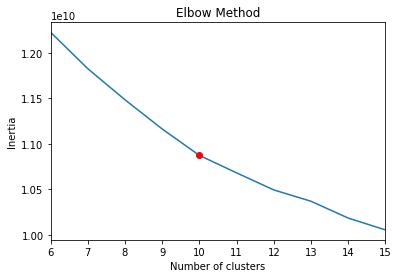

In [20]:
#Elbow Method
seed = 0
elbow = dict()
for k in range(6,16):
    estimator = KMeans(n_clusters = k,random_state=seed)
    res = estimator.fit_predict(X_train)
    inertia = estimator.inertia_
    elbow[k] = inertia
    
elbow_df = pd.Series(elbow)
ax = elbow_df.plot(title = 'Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
plt.plot(10,elbow_df[10],'ro')

From the above plot it looks like we are uanble to find the optimal number of clusters; i.e if it is between 8 - 14.Therefore we can try using other methods such as Silhouette Score or BIC score with a Gaussian Mixture Model to predict the accurate number of clusters.

For n_clusters = 8 The average silhouette_score is : 0.10950208148743205


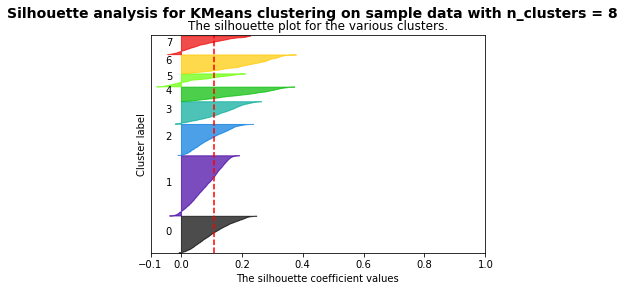

For n_clusters = 9 The average silhouette_score is : 0.10786930513596428


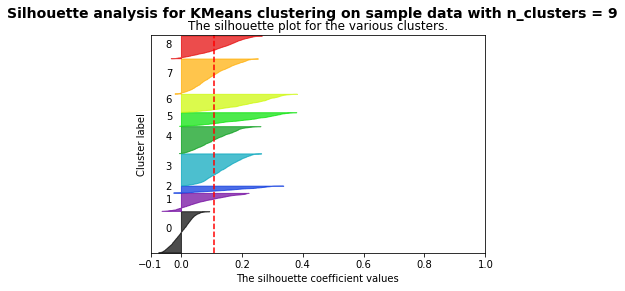

For n_clusters = 10 The average silhouette_score is : 0.1093898821811964


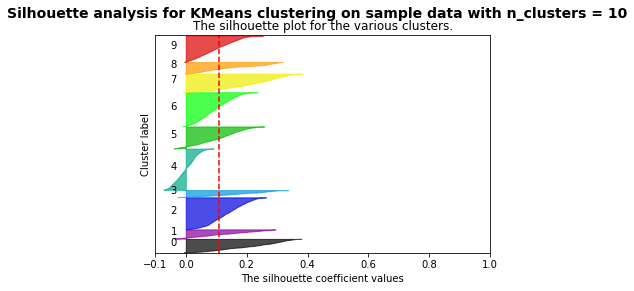

For n_clusters = 11 The average silhouette_score is : 0.10569737274963036


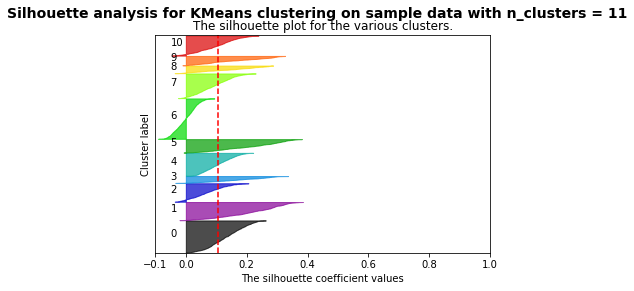

For n_clusters = 12 The average silhouette_score is : 0.103117611091052


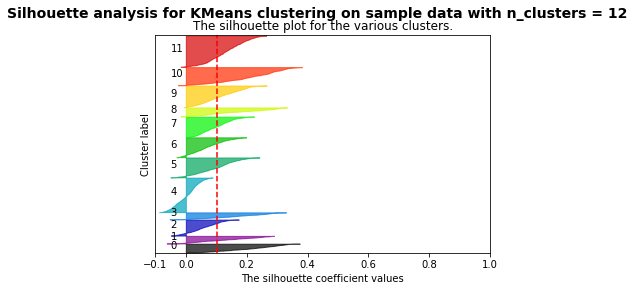

For n_clusters = 13 The average silhouette_score is : 0.10509957050666918


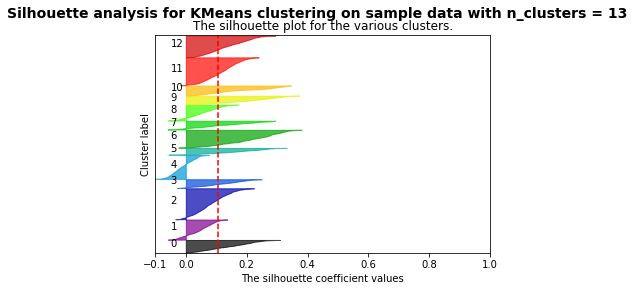

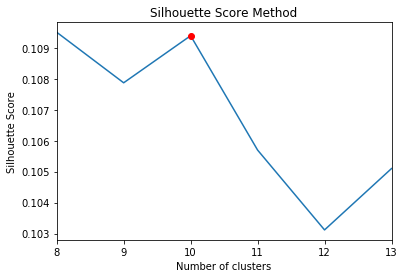

In [21]:
# Silhouette Score Method
seed = 0
dict_silhouette_avg = dict()
range_n_clusters = range(8,14)

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X_train.shape[0] + (n_clusters + 1) * 10])
    
    estimator = KMeans(n_clusters = n_clusters,random_state=seed)
    cluster_labels = estimator.fit_predict(X_train)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train,cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    dict_silhouette_avg[n_clusters] = silhouette_avg
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train,cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
silhouette_df = pd.Series(dict_silhouette_avg)
ax = silhouette_df.plot(title = 'Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
plt.plot(10,silhouette_df[10],'ro')

In [22]:
KM = KMeans(n_clusters = 10, random_state=seed)
res = KM.fit_predict(X_train)

label_pred_KM = KM.labels_
print("Labels predicted by K-Means:",label_pred_KM)
print('Length of labels is same as data entry', label_pred_KM.shape)

centroids_KM= KM.cluster_centers_
print("Shape of centroids_KM",centroids_KM.shape)
print("Centroids:",centroids_KM)

inertia_KM = KM.inertia_
print("Inertia:",inertia_KM)

Labels predicted by K-Means: [0 0 0 ... 2 2 2]
Length of labels is same as data entry (7472,)
Shape of centroids_KM (10, 896)
Centroids: [[ 1.59486169e+02  1.93343838e+01  1.68464636e+02 ... -3.40756631e-01
  -3.84500845e-02 -1.63751533e-02]
 [ 1.46262422e+02  2.23035714e+01  1.03148551e+02 ...  1.79363221e-01
   2.70432720e-01 -3.98986399e-17]
 [ 1.67360358e+02  3.90741494e+01  1.87079193e+02 ... -3.35745224e-02
  -7.51834516e-02 -6.85806495e-02]
 ...
 [ 1.57947375e+02  2.70280840e+01  1.45455512e+02 ... -2.15932987e-01
  -2.84453339e-01 -4.33680869e-17]
 [ 1.60335013e+02  2.97371956e+01  1.58015953e+02 ...  3.21834940e-01
   1.64508124e-01 -3.98986399e-17]
 [ 1.54410897e+02  2.68338828e+01  1.52738828e+02 ...  1.50676583e-01
   2.78356782e-02 -4.33680869e-17]]
Inertia: 10873683074.15985


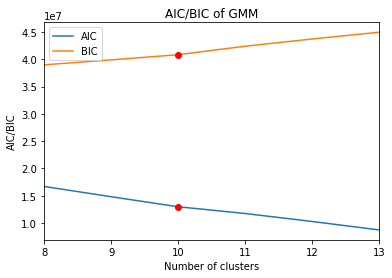

In [23]:
aic = dict()
bic = dict()
for k in range(8,14):
    estimator = GaussianMixture(n_components = k, random_state=seed)
    res = estimator.fit(X_train)
    ic1 = estimator.aic(X_train)
    ic2 = estimator.bic(X_train)
    aic[k] = ic1
    bic[k] = ic2
    
aic_df = pd.Series(aic)
bic_df = pd.Series(bic)

temp = {'AIC' : aic_df,
     'BIC' : bic_df}
ic_df = pd.DataFrame(temp)
ax = ic_df.plot(title='AIC/BIC of GMM')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC/BIC')
plt.plot(10,aic_df[10],'ro')
plt.plot(10,bic_df[10],'ro')

## Clustering Algorithms

### Spectral Clustering



init		time	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________
Spectral 	1.59s	0.002	0.005	0.003	-0.000	-0.000	-0.186
__________________________________________________
Accuracy Score: 		28.6839%
Recall (Sensitivity): 		46.6408%
Specificity Score: 		21.1336%
False Positive Rate: 		78.8664%
Precision Score: 		19.9144%
F-Score: 			27.9114%
__________________________________________________


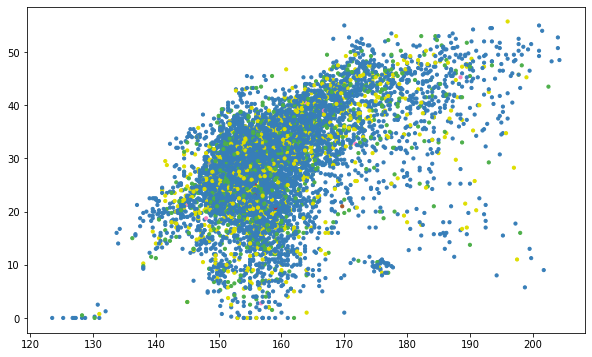

In [24]:
#Spectral Clustering
estimator = SpectralClustering(n_clusters=n_labels).fit(X_train)
pred_labels = estimator.labels_
#Print Metrics
cluster_metrics(pred_labels, name="Spectral", data=X_train, labels = y_train)
cluster_matrix = metrics.cluster.contingency_matrix(y_train,estimator.fit_predict(X_train))
accuracy_metrics(cluster_matrix)
plot_cluster(pred_labels,X_train)
metrics_df = metrics_df.append(scores_df)

### KMeans



init		time	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________
KMeans++ 	1.69s	0.478	0.493	0.485	0.311	0.484	0.110
__________________________________________________
Accuracy Score: 		53.6822%
Recall (Sensitivity): 		59.1225%
Specificity Score: 		48.1508%
False Positive Rate: 		51.8492%
Precision Score: 		53.6899%
F-Score: 			56.2754%
__________________________________________________


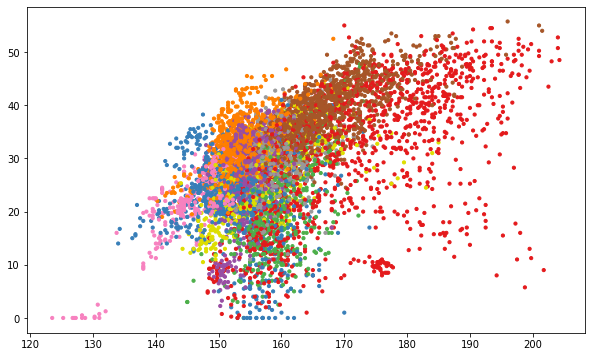

In [25]:
# KMeans Clustering
estimator = KMeans(init='k-means++', n_clusters=n_labels, n_init=10).fit(X_train)
pred_labels = estimator.labels_
#Print Metrics
cluster_metrics(pred_labels, name="KMeans++", data=X_train, labels = y_train)
cluster_matrix = metrics.cluster.contingency_matrix(y_train,estimator.fit_predict(X_train))
accuracy_metrics(cluster_matrix)
plot_cluster(pred_labels,X_train)
metrics_df = metrics_df.append(scores_df)

### MiniBatch KMeans



init		time	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________
MiniBatchKMeans	1.56s	0.449	0.462	0.455	0.304	0.454	0.103
__________________________________________________
Accuracy Score: 		56.8369%
Recall (Sensitivity): 		56.5250%
Specificity Score: 		57.1290%
False Positive Rate: 		42.8710%
Precision Score: 		55.2623%
F-Score: 			55.8866%
__________________________________________________


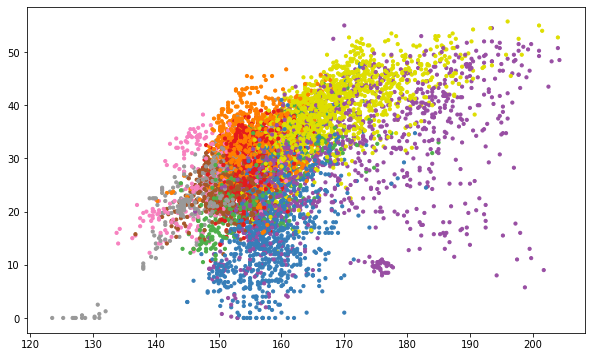

In [26]:
# MiniBatch KMeans clustering
estimator = MiniBatchKMeans(
    init='random',
    n_clusters=n_labels,
    batch_size=sample_size).fit(X_train)
pred_labels = estimator.predict(X_train)
#Print Metrics
cluster_metrics(pred_labels, name="MiniBatchKMeans", data=X_train, labels = y_train)
cluster_matrix = metrics.cluster.contingency_matrix(y_train,estimator.fit_predict(X_train))
accuracy_metrics(cluster_matrix)
plot_cluster(pred_labels,X_train)
metrics_df = metrics_df.append(scores_df)

### GMM Clustering



init		time	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________
GMM      	1.66s	0.440	0.446	0.443	0.299	0.442	0.092
__________________________________________________
Accuracy Score: 		51.4840%
Recall (Sensitivity): 		56.6119%
Specificity Score: 		45.8284%
False Positive Rate: 		54.1716%
Precision Score: 		53.5442%
F-Score: 			55.0353%
__________________________________________________


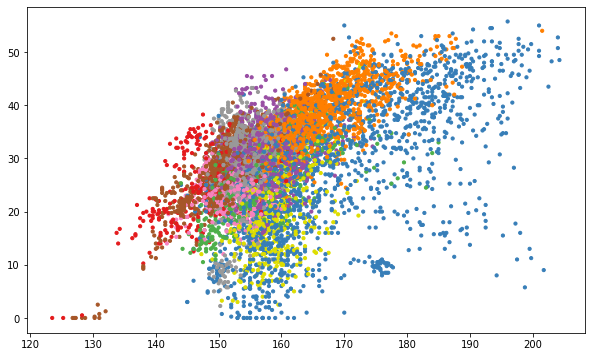

In [27]:
# GMM clustering
estimator = GaussianMixture(n_components=n_labels, random_state=123, covariance_type="full").fit(X_train)
pred_labels = estimator.predict(X_train)
#Print Metrics
cluster_metrics(pred_labels, name="GMM", data=X_train, labels = y_train)
cluster_matrix = metrics.cluster.contingency_matrix(y_train,estimator.fit_predict(X_train))
accuracy_metrics(cluster_matrix)
plot_cluster(pred_labels,X_train)
metrics_df = metrics_df.append(scores_df)

In [28]:
metrics_df = metrics_df.reset_index(drop=True)

,Adjusted Rand Index,Name,Silhouette Score
0,-0.000017,Spectral,-0.186200
1,0.310765,KMeans++,0.109549
2,0.304048,MiniBatchKMeans,0.102853
3,0.299098,GMM,0.092238


In [ ]:
metrics_df.reindex(columns=metrics_cols)
metrics_df

Based on the above plots and performance metrics we choose K-Means Clustering with highest ARI and Silouette Scores. We will visualize these clusters and try to gain insights.

### Cluster Visualization

In [29]:
# KMeans Clustering
pred_labels = KMeans(init='k-means++', n_clusters=n_labels, n_init=10).fit_predict(X_train)

In [30]:
#To select 1st 2 columns, X_train.ix[:, 0:1]
df = all_features_df[all_features_df['fold']!=10]
df=pd.concat([df, pd.DataFrame({'cluster':pred_labels})], axis=1)
df.head()

,features,label,file_name,fold,cluster
0,"[157.5, 12.5, 163.5, 111.25, 182.25, 32.5, 89....",3,UrbanSound8K/audio/fold1/101415-3-0-2.wav,1,2
1,"[160.25, 13.5, 165.0, 113.0, 180.0, 25.75, 105...",3,UrbanSound8K/audio/fold1/101415-3-0-3.wav,1,2
2,"[156.75, 6.5, 156.0, 137.0, 163.25, 34.0, 94.7...",3,UrbanSound8K/audio/fold1/101415-3-0-8.wav,1,2
3,"[158.0, 31.0, 154.0, 85.0, 242.0, 26.0, 122.0,...",3,UrbanSound8K/audio/fold1/102106-3-0-0.wav,1,2
4,"[163.5, 26.0, 164.5, 139.0, 238.5, 23.5, 71.0,...",6,UrbanSound8K/audio/fold1/102305-6-0-0.wav,1,7


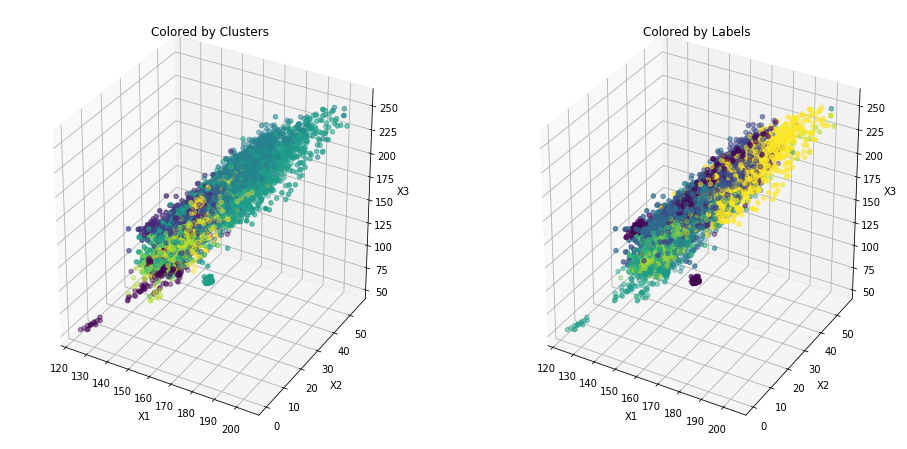

In [31]:
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure(figsize=plt.figaspect(0.35))
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(X_train[0], X_train[1], X_train[2], c=pred_labels)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Colored by Clusters')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.scatter(X_train[0], X_train[1], X_train[2], c=df.label)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Colored by Labels')

fig.savefig('Clusters 3D Plot.png',dpi=300)

plt.show()


In [32]:
df.shape

(7472, 5)

In [33]:
df.columns

Index(['features', 'label', 'file_name', 'fold', 'cluster'], dtype='object')

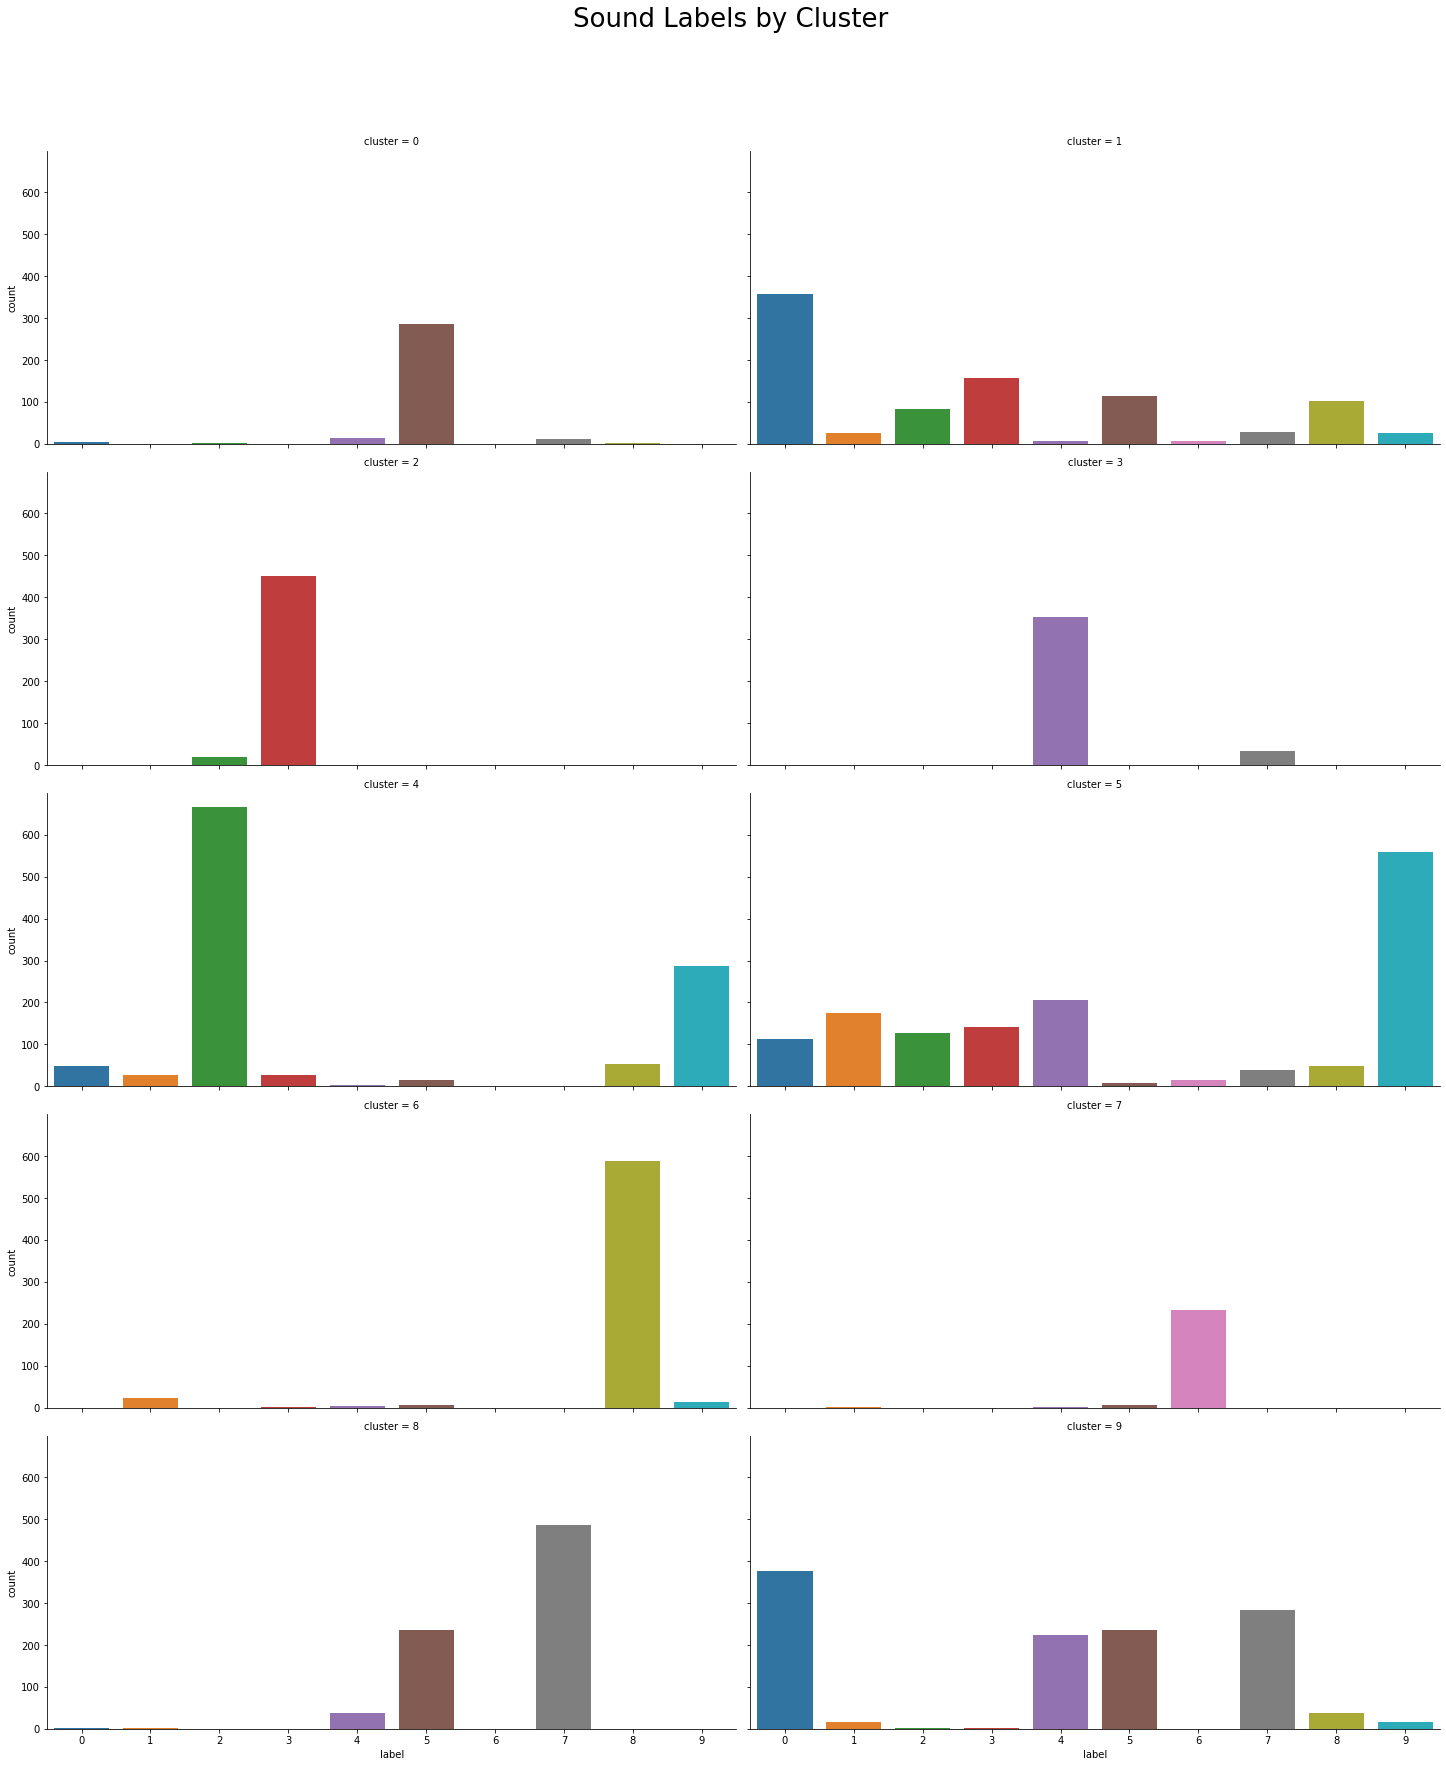

In [34]:
sns.factorplot("label", col="cluster", col_wrap=2,data=df,kind="count", aspect=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Sound Labels by Cluster', fontsize=26)
plt.show()


### t-SNE Visualization

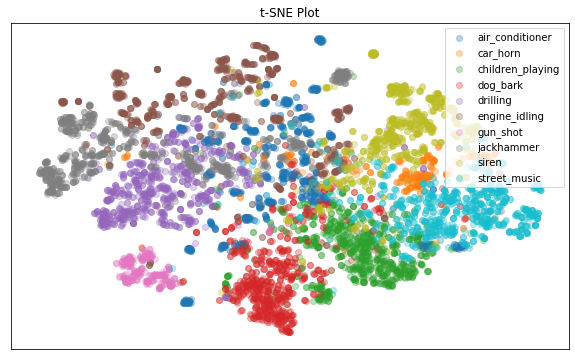

In [35]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
           'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

from sklearn.manifold import TSNE
tsne_vggish = TSNE(2)
U_vggish = tsne_vggish.fit_transform(X_train)
for i, cls in enumerate(classes):
    plt.scatter(U_vggish[y_train==i,0], U_vggish[y_train==i,1], label=cls, alpha=0.3, edgecolors=None)
plt.title('t-SNE Plot')
plt.xticks([])
plt.yticks([])
plt.legend();


### Cluster Highlights

*The clustering algorithm was unable to distinguish between air conditioner, drilling, engine idling and jackhammer, and placed them in cluster 4. Cluster 1, 2, 7, 8 and 9 are more ditinguishable compared to other clusters.*

|   Cluster  |   Class ID|  Description  |
|:--------------|:--------------|:--------------|
| 0 |   9  | primary **9-street music**, secondary **1-car horn, 2-children playing, 3-dog bark, 4-drilling**|
| 1 |   7  | primary **7-jackhammer**, secondary **5-engine idling**|
| 2 |   8  | **8-siren**|
| 3 |   4  | **drilling**|
| 4 |   0  | Mixed **0-air conditioner, 4-drilling, 5-engine idling and 7-jackhammer**|
| 5 |   6  | **6-gun shot**|
| 6 |   2  | primary **2-children playing**, secondary **9-street music**|
| 7 |   3  | **3-dog bark**|
| 8 |   0  | primary **0-airconditioner**, secondary **3-dog bark, 5-engine idling, 8-siren**|
| 9 |   5  | **5-engine idling**|




## Other Clustering Approaches

### Mean Shift

Mean shift makes no assumptions about the nature of the data or the number of clusters, making it more versatile than 𝑘-means, but it creates clusters where data points form a "globe" around a central point. It works for data sets where many clusters are suspected.

Let's see how MeanShift clusters our audio dataset:

In [36]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=sample_size)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 1


The number of estimated clusters is certainly not 1. We know that through the audio files that we have listened before and logically, we cannot expect all audio recordings to have a uniform behavior 

### Affinity Propagation

This algorithm is based on the idea of data points' ability to represent each other through similarity. It defines a similarity matrix that helps in understanding similarity of these points to each other. Then there would be a clustering matrix where similarity has been decided and the algorithm goes towards maximizing similarity for cluster coherence.

It uses availability and responsibility as parameters to deciding how cluster coherence is maximized. Candidate exemplar points send availability information to points which would be in its cluster, their response would be responsibility.

All of this is encompassed in the next block of code, showing the work of Affinity Propagation:

In [37]:
# Declare the model and fit it.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 0


## Conclusions

The reason that kMeans is most widely used in clustering method is due to its performance and simplicity.

Other clustering algorithms with better features tend to be more expensive. In this case, k-means becomes a great solution for pre-clustering, reducing the space into disjoint smaller sub-spaces where other clustering algorithms can be applied.

We did not even have to evaluate MeanShift and Affinity Propagation model clusters using metrics due to the cluster output being illogical, where the kMeans performed much better and gave output that could be interpreted by humans.

## Practical Uses

The automatic classification of audio events in an urban setting has a variety of applications. Some of them are listed below.

- Audio Event Detection
- Home security or Audio Surveillance
- Assisted living, elder or infant care
- Accident and crime surveillance

For example, a baby crying, a person screaming, or someone calling for help are just some audio events that require action. Manually monitoring for these sounds, either in close proximity or remotely through a monitoring device, not only demands attention but also requires the person to be within hearing distance. This is not always possible, and is where audio event detection, or sound recognition, solves real problems. It will automatically alerts an application if a specific sound is detected, so that a human may take the appropriate action.


## Future Considerations

This capstone project focuses on the unsupervised machine learning to draw inferences from datasets consisting of **Unstructured Data**  without labeled responses. We used **Cluster Analysis** which is the most common unsupervised learning method for exploratory data analysis and to group unsorted information according to similarities, patterns and differences without any prior training of data.


- In the near future, we can use **Supervised Learning** to model the data to give us predictive power to classify the sonic events accurately. Improving this model to encompass several different methods to optimize prediction of the audio classification. In addition to the  modeling, one can also implement tensorflows, keras and neural networks.


- By modeling and interpreting the data, we can potentially improve the quality of life of city dwellers by providing a data-driven understanding of urban sound and noise patterns, partly enabled by the move towards *“smart cities”* equipped with multimedia sensor networks. 

## References

1. [VGGish Audio Embedding Colab](https://colab.research.google.com/drive/1TbX92UL9sYWbdwdGE0rJ9owmezB-Rl1C#scrollTo=DaMrmOEvC7L4)

2. [Unsupervised Feature Learning for Urban Sound Classification](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_unsupervisedlearning_urbansound_icassp_2015.pdf)